<a href="https://colab.research.google.com/github/scdivad/CS521/blob/main/CS521_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Q1 Setep
Do not run for Q2 due to dependency issues


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50,50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = self.fc(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = Net()

model = model.to(device)
model.train()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:11<00:00, 897762.26it/s] 


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 136080.00it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1291326.73it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 5330310.23it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



Net(
  (fc): Linear(in_features=784, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Natural accuracy: {100 * correct / total}')

In [ ]:
# HW1

def fgsm(model, x, labels, eps_step, targeted):
    model.eval()
    x.requires_grad_()
    outputs = model(x)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    adv_x = x + (-1 if targeted else +1) * eps_step * x.grad.sign()
    return torch.clamp(adv_x, 0, 1)

def pgd_untargeted(model, x, y, k, eps, eps_step):
    model.eval()
    lb = x - eps
    ub = x + eps
    for i in range(k):
        x = fgsm(model, x, y, eps_step, targeted=False).detach()
        x = torch.clamp(x, lb, ub)
    return x

In [ ]:
# HW1
def test_model_on_attacks(model, attack='pgd', attack_epochs=20, eps=0.1, c=1, num_examples_show=0):
    model.eval()

    correct = 0
    total = 0
    original_images_list = []
    attacked_images_list = []
    labels_list = []
    predictions_list = []
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        correct_indices = torch.max(model(images), 1)[1] == labels
        if attack == 'pgd':
            images_attacked = pgd_untargeted(model, images, labels, attack_epochs, eps, 0.01)
        else:
            images_attacked = images

        outputs = model(images_attacked)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # only attach images that were correctly classified to begin with
        if num_examples_show:
            original_images_list.append(images[correct_indices].cpu().detach().numpy())
            attacked_images_list.append(images_attacked[correct_indices].cpu().detach().numpy())
            labels_list.append(labels[correct_indices].cpu().detach().numpy())
            predictions_list.append(predicted[correct_indices].cpu().detach().numpy())

    if num_examples_show:
        original_images_list = np.concatenate(original_images_list)
        attacked_images_list = np.concatenate(attacked_images_list)
        labels_list = np.concatenate(labels_list)
        predictions_list = np.concatenate(predictions_list)

        num_samples = min(num_examples_show, original_images_list.shape[0])
        # only choose examples of images where the attack was successful
        indices = np.where(predictions_list != labels_list)[0]
        indices = indices[:num_samples]
        for i in indices:
            plt.figure(figsize=(5, 2.5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_images_list[i].reshape(28, 28), cmap='gray')
            plt.subplot(1, 2, 2)
            plt.imshow(attacked_images_list[i].reshape(28, 28), cmap='gray')
            plt.title(f'{"Successful" if predictions_list[i] != labels_list[i] else "Unsuccessful"} Attack: {predictions_list[i]}')
            plt.show()
    print(f'Robust accuracy on {attack} {eps} images: {100 * correct / total}')



In [ ]:
def test_model_verified_accuracy(model, eps=0.1):
    model.eval()

    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        lower, upper = IBP_bounds(model, images.view(images.shape[0], -1), eps)
        # count number of testing labels in batch where lb of the label is greater than the ub of any incorrect class
        upper[torch.arange(images.shape[0]), labels] = -1e9
        correct += (lower[torch.arange(images.shape[0]), labels] > upper.max(dim=-1)[0]).sum().item()
        total += labels.size(0)

    print(f'Verified accuracy: {100 * correct / total}')

# Q1 main

In [ ]:
def IBP_bounds(net, x0, eps):
    lower = x0 - eps
    upper = x0 + eps
    num_layers = len(list(net.children()))
    for i, layer in enumerate(net.children()):
        if isinstance(layer, nn.Linear):
            W = layer.weight
            b = layer.bias
            pos_W = torch.clamp(W, min=0)
            neg_W = torch.clamp(W, max=0)
            lower2 = upper @ neg_W.T + lower @ pos_W.T + b
            upper2 = upper @ pos_W.T + lower @ neg_W.T + b
            lower, upper = lower2, upper2
        elif isinstance(layer, nn.ReLU):
            lower = torch.clamp(lower, min=0)
            upper = torch.clamp(upper, min=0)
    return (lower, upper)


In [ ]:
def train_nat_model(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')

In [ ]:
def train_robust_model(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    kappa = 1
    eps = 0

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        for i, data in enumerate(train_loader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            batch_size = images.shape[0]

            optimizer.zero_grad()
            outputs = model(images)

            ibp_lb, ibp_ub = IBP_bounds(model, images.view(batch_size, -1), eps)
            z = ibp_ub # this is a pointer, careful
            z[torch.arange(batch_size), labels] = ibp_lb[torch.arange(batch_size), labels]
            z = torch.softmax(z, dim=-1)
            loss = kappa * criterion(outputs, labels) + (1 - kappa) * criterion(z, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')

        kappa -= 0.5 / (num_epochs-1)
        eps += 0.1 / (num_epochs-1)


In [ ]:
path = '/content/drive/MyDrive/CS521/weights_nat_HW3.pt'
model_nat = Net()
model_nat = model_nat.to(device)
if not os.path.exists(path):
    start_time = time.time()
    train_model(model_nat, num_epochs=100)
    torch.save(model_nat.state_dict(), path)
    end_time = time.time()
    print("Elapsed: ", end_time - start_time)
else:
    model_nat.load_state_dict(torch.load(path))

Epoch 1/100, Loss: 0.413
Epoch 2/100, Loss: 0.204
Epoch 3/100, Loss: 0.167
Epoch 4/100, Loss: 0.147
Epoch 5/100, Loss: 0.140
Epoch 6/100, Loss: 0.138
Epoch 7/100, Loss: 0.140
Epoch 8/100, Loss: 0.145
Epoch 9/100, Loss: 0.151
Epoch 10/100, Loss: 0.158
Epoch 11/100, Loss: 0.165
Epoch 12/100, Loss: 0.174
Epoch 13/100, Loss: 0.181
Epoch 14/100, Loss: 0.190
Epoch 15/100, Loss: 0.200
Epoch 16/100, Loss: 0.209
Epoch 17/100, Loss: 0.218
Epoch 18/100, Loss: 0.227
Epoch 19/100, Loss: 0.239
Epoch 20/100, Loss: 0.248
Epoch 21/100, Loss: 0.258
Epoch 22/100, Loss: 0.269
Epoch 23/100, Loss: 0.280
Epoch 24/100, Loss: 0.291
Epoch 25/100, Loss: 0.302
Epoch 26/100, Loss: 0.312
Epoch 27/100, Loss: 0.324
Epoch 28/100, Loss: 0.333
Epoch 29/100, Loss: 0.345
Epoch 30/100, Loss: 0.358
Epoch 31/100, Loss: 0.369
Epoch 32/100, Loss: 0.377
Epoch 33/100, Loss: 0.390
Epoch 34/100, Loss: 0.401
Epoch 35/100, Loss: 0.415
Epoch 36/100, Loss: 0.423
Epoch 37/100, Loss: 0.436
Epoch 38/100, Loss: 0.448
Epoch 39/100, Loss: 0

In [ ]:
path = '/content/drive/MyDrive/CS521/weights_ibp_HW3.pt'
model_ibp = Net()
model_ibp = model_ibp.to(device)
if not os.path.exists(path):
    start_time = time.time()
    train_robust_model(model_ibp, num_epochs=100)
    torch.save(model_ibp.state_dict(), path)
    end_time = time.time()
    print("Elapsed: ", end_time - start_time)
else:
    model_ibp.load_state_dict(torch.load(path))

Epoch 1/100, Loss: 0.404
Epoch 2/100, Loss: 0.194
Epoch 3/100, Loss: 0.159
Epoch 4/100, Loss: 0.143
Epoch 5/100, Loss: 0.138
Epoch 6/100, Loss: 0.137
Epoch 7/100, Loss: 0.140
Epoch 8/100, Loss: 0.145
Epoch 9/100, Loss: 0.151
Epoch 10/100, Loss: 0.158
Epoch 11/100, Loss: 0.165
Epoch 12/100, Loss: 0.172
Epoch 13/100, Loss: 0.182
Epoch 14/100, Loss: 0.190
Epoch 15/100, Loss: 0.200
Epoch 16/100, Loss: 0.210
Epoch 17/100, Loss: 0.219
Epoch 18/100, Loss: 0.229
Epoch 19/100, Loss: 0.240
Epoch 20/100, Loss: 0.249
Epoch 21/100, Loss: 0.259
Epoch 22/100, Loss: 0.270
Epoch 23/100, Loss: 0.280
Epoch 24/100, Loss: 0.291
Epoch 25/100, Loss: 0.302
Epoch 26/100, Loss: 0.314
Epoch 27/100, Loss: 0.324
Epoch 28/100, Loss: 0.335
Epoch 29/100, Loss: 0.348
Epoch 30/100, Loss: 0.357
Epoch 31/100, Loss: 0.368
Epoch 32/100, Loss: 0.380
Epoch 33/100, Loss: 0.391
Epoch 34/100, Loss: 0.403
Epoch 35/100, Loss: 0.414
Epoch 36/100, Loss: 0.424
Epoch 37/100, Loss: 0.437
Epoch 38/100, Loss: 0.449
Epoch 39/100, Loss: 0

In [ ]:
print("Natural trained results")
test_model(model_nat)
for eps_test in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]:
    test_model_on_attacks(model_nat, attack='pgd', eps=eps_test)
for eps_test in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]:
    test_model_verified_accuracy(model_nat, eps=eps_test)

Natural trained results
Natural accuracy: 96.81
Robust accuracy on pgd 0.01 images: 93.72
Robust accuracy on pgd 0.02 images: 87.08
Robust accuracy on pgd 0.03 images: 75.47
Robust accuracy on pgd 0.04 images: 63.66
Robust accuracy on pgd 0.05 images: 52.7
Robust accuracy on pgd 0.06 images: 43.2
Robust accuracy on pgd 0.07 images: 35.61
Robust accuracy on pgd 0.08 images: 29.88
Robust accuracy on pgd 0.09 images: 25.54
Robust accuracy on pgd 0.1 images: 22.41
Verified accuracy: 23.65
Verified accuracy: 17.45
Verified accuracy: 16.45
Verified accuracy: 15.69
Verified accuracy: 14.77
Verified accuracy: 13.74
Verified accuracy: 12.51
Verified accuracy: 11.24
Verified accuracy: 10.08
Verified accuracy: 8.85


In [ ]:
print("IBP trained results")
test_model(model_ibp)
for eps_test in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]:
    test_model_on_attacks(model_ibp, attack='pgd', eps=eps_test)
for eps_test in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]:
    test_model_verified_accuracy(model_ibp, eps=eps_test)

IBP trained results
Natural accuracy: 96.91
Robust accuracy on pgd 0.01 images: 93.89
Robust accuracy on pgd 0.02 images: 88.76
Robust accuracy on pgd 0.03 images: 79.44
Robust accuracy on pgd 0.04 images: 67.29
Robust accuracy on pgd 0.05 images: 55.57
Robust accuracy on pgd 0.06 images: 46.28
Robust accuracy on pgd 0.07 images: 38.97
Robust accuracy on pgd 0.08 images: 32.74
Robust accuracy on pgd 0.09 images: 28.01
Robust accuracy on pgd 0.1 images: 24.36
Verified accuracy: 23.37
Verified accuracy: 17.12
Verified accuracy: 16.09
Verified accuracy: 15.34
Verified accuracy: 14.4
Verified accuracy: 13.34
Verified accuracy: 12.21
Verified accuracy: 11.05
Verified accuracy: 9.66
Verified accuracy: 8.61


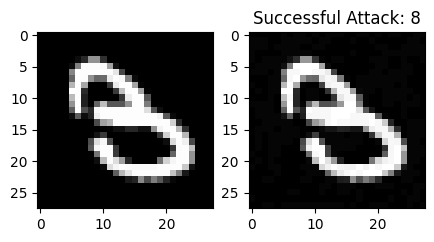

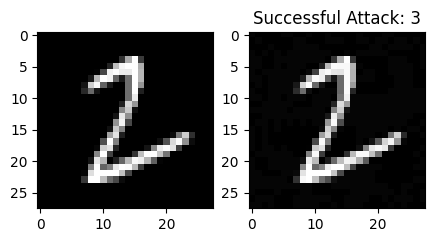

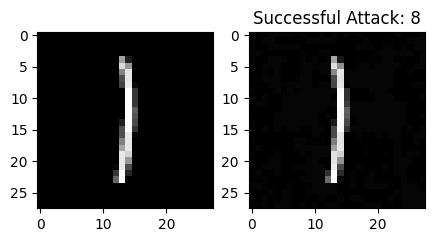

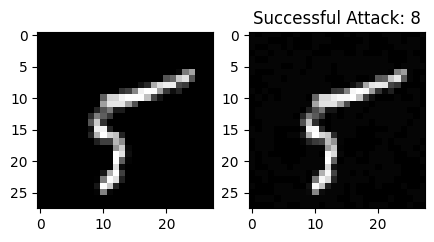

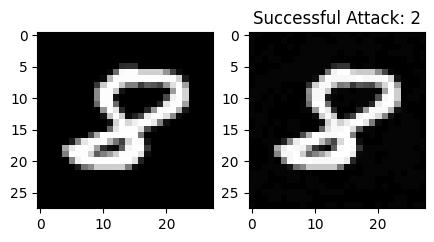

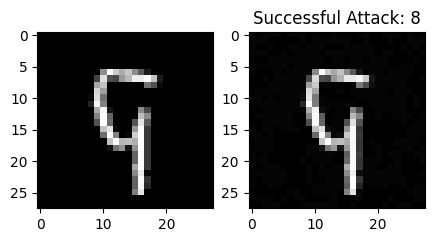

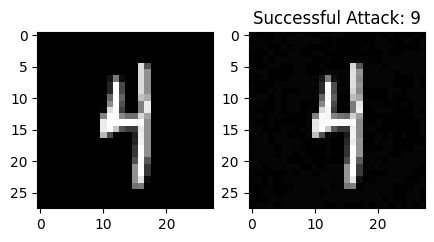

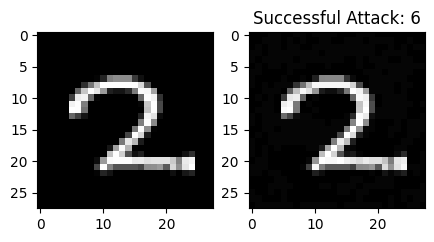

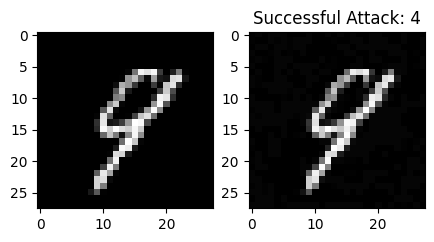

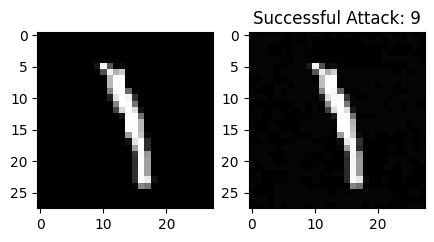

Robust accuracy on pgd 0.02 images: 88.76


In [ ]:
test_model_on_attacks(model_ibp, attack='pgd', eps=0.02, num_examples_show=10)

# Q2 Setup part 1
Libraries installation, imports

In [ ]:
!pip install torch==2.3.0 torchtext==0.18.0 torchvision torchdata portalocker>=2.0.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 2.3.0 which is incompatible.


In [ ]:
%cd /content/drive/MyDrive/CS521

/content/drive/MyDrive/CS521


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter
import time
import torch.nn.functional as F
import os

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# Q2 Setup part 2
Model definition, dataset prep

In [ ]:
cnt1 = 0
cnt2 = 0
for label, line in IMDB(split='test'):
    if label == 1: cnt1 += 1
    else: cnt2 += 1
cnt1, cnt2

(12500, 12500)

In [ ]:
train_iter = IMDB(split='train')
imdbtoken_to_id = {}
imdbtoken_to_id['<PAD>'] = 0
for label, line in train_iter:
    for token in line.split():
        if token not in imdbtoken_to_id:
            imdbtoken_to_id[token] = len(imdbtoken_to_id)
len(imdbtoken_to_id)

280618

In [ ]:
embeddings = {}
d_embed = 300
with open('glove.840B.300d.txt', 'r') as f:
    for line in f:
        glove_line = line.strip().split()
        glove_token = "".join(glove_line[:-d_embed])
        glove_emb = torch.tensor([float(x) for x in glove_line[-d_embed:]], dtype=torch.float32)
        if glove_token in imdbtoken_to_id:
            embeddings[glove_token] = glove_emb
len(embeddings)

85246

In [ ]:
d_embed = 300
d_vocab = len(imdbtoken_to_id)
embedding_matrix = torch.zeros(d_vocab, d_embed)

for word, id in imdbtoken_to_id.items():
    if word in embeddings:
        embedding_matrix[id] = embeddings[word]

mean_embed = torch.mean(embedding_matrix, dim=0)
embedding_matrix[0] = mean_embed

In [ ]:
embedding_matrix = embedding_matrix.to(device)

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data_iter, vocab, max_length):
        self.vocab = vocab
        self.max_length = max_length
        self.samples = []

        for label, line in data_iter:
            tokens = line.split(' ')
            indices = [vocab.get(token, vocab['<PAD>']) for token in tokens]
            if len(indices) < max_length:
                indices += [vocab['<PAD>']] * (max_length - len(indices))
            else:
                indices = indices[:max_length]
            label_tensor = torch.tensor(label, dtype=torch.long) - 1  # Convert label to (0,1) instead of (1,2)
            self.samples.append((torch.tensor(indices, dtype=torch.long), label_tensor))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

seq_length = 200
train_dataset = IMDBDataset(IMDB(split='train'), imdbtoken_to_id, seq_length)
test_dataset = IMDBDataset(IMDB(split='test'), imdbtoken_to_id, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings, seq_length):
        super(SentimentNet, self).__init__()
        self.seq_length = seq_length

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.embedding.weight.requires_grad = False

        self.linear_emb = nn.Linear(embedding_dim, embedding_dim)
        self.relu_emb = nn.ReLU()

        self.mean_linear = nn.Linear(self.seq_length, 1, bias=False)
        with torch.no_grad():
            self.mean_linear.weight.fill_(1.0 / self.seq_length)
        self.mean_linear.weight.requires_grad = False

        self.fc1 = nn.Linear(embedding_dim, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.relu_emb(self.linear_emb(x))

        # x0 = x.mean(dim=1)
        x = x.transpose(1, 2)
        x = self.mean_linear(x)
        x = x.transpose(1, 2)
        # assert torch.allclose(x, x0.unsqueeze(1))

        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(1)

    def forward_from_embedding(self, x):
        x = x.transpose(1, 2)
        x = self.mean_linear(x)
        x = x.transpose(1, 2)

        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(1)


# Q2 Setup part 3
Natural training, natural testing, empirical robustness testing, verified robustness testing

In [ ]:
def test_natural_acc(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in data_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    print(f'Natural accuracy: {correct / total}')

In [ ]:
def test_model_verified_accuracy(model, eps=0.1):
    model.eval()
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        lower, upper = IBP_bounds_IMDB(model, model.embedding(images), eps)
        # count number of testing labels in batch where lb of the label is greater than the ub of any incorrect class
        upper[torch.arange(images.shape[0]), labels] = -1e9
        correct += (lower[torch.arange(images.shape[0]), labels] > upper.max(dim=-1)[0]).sum().item()
        total += labels.size(0)

    print(f'Verified accuracy: {100 * correct / total}')

In [ ]:
def fgsm_IMDB(model, x_embed, labels, eps_step, targeted):
    model.eval()
    x_embed.requires_grad_()
    outputs = model.forward_from_embedding(x_embed)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    adv_x = x_embed + (-1 if targeted else +1) * eps_step * x_embed.grad.sign()
    return torch.clamp(adv_x, 0, 1)

def pgd_untargeted_IMDB(model, x, y, k, eps, eps_step):
    model.eval()
    x_embed = model.embedding(x)
    lb = x_embed - eps
    ub = x_embed + eps
    for i in range(k):
        x = fgsm(model, x_embed, y, eps_step, targeted=False).detach()
        x = torch.clamp(x, lb, ub)
    return x

In [ ]:
def train_IMDB_nat(model, num_epochs):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_inputs, batch_labels in train_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [ ]:
def test_IMDB_model_on_PGD(model, attack_epochs=20, eps=0.1):
    model.eval()
    correct = 0
    total = 0
    original_images_list = []
    attacked_images_list = []
    labels_list = []
    predictions_list = []
    for batch_inputs, batch_labels in test_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        correct_indices = torch.max(model(batch_inputs), 1)[1] == batch_labels
        inputs_attacked = pgd_untargeted(model, batch_inputs, batch_labels, attack_epochs, eps, eps/10)

        outputs = model.forward_from_embedding(inputs_attacked)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)

    print(f'Robust accuracy on PGD {eps} images: {100 * correct / total}')

# Q2 main

In [ ]:
def IBP_bounds_IMDB(net, embed_x0, eps):
    lower = embed_x0 - eps
    upper = embed_x0 + eps
    num_layers = len(list(net.children()))
    for i, layer in enumerate(net.children()):
        if i == 0: continue # skip embed layer
        if isinstance(layer, nn.Linear):
            W = layer.weight
            b = layer.bias
            if layer == net.mean_linear:
                lower = lower.transpose(1, 2)
                upper = upper.transpose(1, 2)
                b = torch.zeros(W.shape[0], device=device)
            pos_W = torch.clamp(W, min=0)
            neg_W = torch.clamp(W, max=0)
            lower2 = upper @ neg_W.T + lower @ pos_W.T + b
            upper2 = upper @ pos_W.T + lower @ neg_W.T + b
            lower, upper = lower2, upper2
            if layer == net.mean_linear:
                lower = lower.transpose(1, 2).squeeze(1)
                upper = upper.transpose(1, 2).squeeze(1)
        elif isinstance(layer, nn.ReLU):
            lower = torch.clamp(lower, min=0)
            upper = torch.clamp(upper, min=0)
        else:
            raise NotImplementedError
    return (lower, upper)


In [ ]:
model_nat = SentimentNet(d_vocab, d_embed, embedding_matrix, seq_length)
model_nat = model_nat.to(device)
if not os.path.exists('/content/drive/MyDrive/CS521/weights_IMDB_nat.pt'):
    start_time = time.time()
    train_IMDB_nat(model_nat, num_epochs=10)
    end_time = time.time()
    print("Elapsed: ", end_time - start_time)
    torch.save(model_nat.state_dict(), '/content/drive/MyDrive/CS521/weights_IMDB_nat.pt')
else:
    model_nat.load_state_dict(torch.load('/content/drive/MyDrive/CS521/weights_IMDB_nat.pt'))

Epoch 1/10, Loss: 0.4383
Epoch 2/10, Loss: 0.3717
Epoch 3/10, Loss: 0.3482
Epoch 4/10, Loss: 0.3362
Epoch 5/10, Loss: 0.3244
Epoch 6/10, Loss: 0.3139
Epoch 7/10, Loss: 0.3077
Epoch 8/10, Loss: 0.2904
Epoch 9/10, Loss: 0.2790
Epoch 10/10, Loss: 0.2681
Elapsed:  18.18229651451111


In [ ]:
def robust_training_IMDB(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    kappa = 1
    eps = 0
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_inputs, batch_labels in train_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            batch_size = batch_inputs.shape[0]

            outputs = model(batch_inputs)

            with torch.no_grad():
                batch_inputs_embed = model.embedding(batch_inputs)
            ibp_lb, ibp_ub = IBP_bounds_IMDB(model, batch_inputs_embed, eps)
            z = ibp_ub # this is a pointer, careful
            z[torch.arange(batch_size), batch_labels] = ibp_lb[torch.arange(batch_size), batch_labels]
            z = torch.softmax(z, dim=-1)
            loss = kappa * criterion(outputs, batch_labels) + (1 - kappa) * criterion(z, batch_labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')

        kappa -= 0.5 / (num_epochs-1)
        eps += (emb_range * 0.05) / (num_epochs-1)

    end_time = time.time()
    print("Elapsed: ", end_time - start_time)


In [ ]:
model_ibp = SentimentNet(d_vocab, d_embed, embedding_matrix, seq_length)
model_ibp = model_ibp.to(device)
robust_training_IMDB(model_ibp, num_epochs=10)

Epoch 1/10, Loss: 0.444
Epoch 2/10, Loss: 0.425
Epoch 3/10, Loss: 0.455
Epoch 4/10, Loss: 0.499
Epoch 5/10, Loss: 0.543
Epoch 6/10, Loss: 0.592
Epoch 7/10, Loss: 0.640
Epoch 8/10, Loss: 0.691
Epoch 9/10, Loss: 0.742
Epoch 10/10, Loss: 0.792
Elapsed:  45.383729696273804


In [ ]:
print("Naturally trained results")
test_accuracy = test_natural_acc(model_nat, test_loader)
print()
# epsilon should be around this order of magnitude, considering we use around epsilon=0.1 for MNIST of [0,1]
emb_range = (embedding_matrix.max() - embedding_matrix.min()).item()
for eps_test in [0.01,0.02,0.03,0.04,0.05]:
    epsilon = eps_test * emb_range
    test_IMDB_model_on_PGD(model_nat, eps=epsilon)
print()
for eps_test in [0.01,0.02,0.03,0.04,0.05]:
    epsilon = eps_test * emb_range / 100
    test_model_verified_accuracy(model_nat, eps=epsilon)

Naturally trained results
Natural accuracy: 0.85876

Robust accuracy on PGD 0.08334600448608398 images: 44.492
Robust accuracy on PGD 0.16669200897216796 images: 8.576
Robust accuracy on PGD 0.25003801345825194 images: 0.02
Robust accuracy on PGD 0.3333840179443359 images: 0.0
Robust accuracy on PGD 0.41673002243041996 images: 0.0

Verified accuracy: 67.432
Verified accuracy: 41.364
Verified accuracy: 18.652
Verified accuracy: 5.876
Verified accuracy: 1.212


In [ ]:
print("Robust trained results")
test_natural_acc(model_ibp, test_loader)
print()
emb_range = (embedding_matrix.max() - embedding_matrix.min()).item()
for eps_test in [0.01,0.02,0.03,0.04,0.05]:
    epsilon = eps_test * emb_range
    test_IMDB_model_on_PGD(model_ibp, eps=epsilon)
print()
for eps_test in [0.01,0.02,0.03,0.04,0.05]:
    epsilon = eps_test * emb_range / 100
    test_model_verified_accuracy(model_ibp, eps=epsilon)

Robust trained results
Natural accuracy: 0.85664

Robust accuracy on PGD 0.08334600448608398 images: 44.324
Robust accuracy on PGD 0.16669200897216796 images: 33.004
Robust accuracy on PGD 0.25003801345825194 images: 16.676
Robust accuracy on PGD 0.3333840179443359 images: 1.148
Robust accuracy on PGD 0.41673002243041996 images: 0.004

Verified accuracy: 68.46
Verified accuracy: 43.368
Verified accuracy: 20.652
Verified accuracy: 6.952
Verified accuracy: 1.496
